In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import xgboost

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import model_selection, linear_model, ensemble, tree, svm, neighbors
from sklearn import metrics
from sklearn.inspection import permutation_importance 

## Data info

- **PassengerId** : Unique ID of passenger
- **Survived** : 0 = No, 1 = Yes
- **pclass** : Ticket class `1 = 1st, 2 = 2nd, 3 = 3rd`
- **sibsp** : # of siblings & spouses aboard the Titanic
- **parch** : # of parents / children aboard the Titanic
- **ticket** : Ticket number
- **cabin** : Cabin number
- **embarked** : Port of Embarkation `C = Cherbourg, Q = Queenstown, S = Southampton`
- **Fare** : 운임


<br>

## 1. Preparing dataset (2번부터 실습 진행)

In [2]:
data_df = pd.read_csv('./titanic.csv')
data_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
df1 = data_df.copy()

In [4]:
y_data = df1[['Survived']]
y_data

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,0
889,1


In [5]:
del df1['Survived']
x_data = df1
x_data = x_data[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
x_data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<br>

## 2. Feature engineering & Feature selection

#### 시도해볼 수 있는 전략들

- 불필요한 열이나 예측에 방해가 되는 열은 아예 지우기 (ex. PassengerId)
- 결측치 채우기 
- Text로 되어있는 Category(Factor)는 숫자로 바꿔주기 (ex. Male/Female -> 0/1)
- 실수 범위를 구간 범위로 바꿔주기 (구간으로 나눌 필요 없음)
- 필요한 경우 기존 열을 바탕으로 새로운 열을 계산해 추가하기

## 2-1 Age 컬럼의 결측치 처리하기
> * Age칼럼의 데이터는  `Numerical Data`이다 : <br>
> * 칼럼의 결측치를 대푯값 (평균, 중앙, 최빈값)으로 각각 처리해보고 분류모델의 성능이 가장 잘 나오는 모델을 사용하기로 결정 <br>
> * 모든 칼럼 중 우선적으로 Age칼럼의 결측치 처리를 위해 numerical column 모두와 object칼럼 중 성별 데이터를 feature로 사용하여 모델링 진행

### 2-1-1 모델을 돌리기 위한 성별 데이터 인코딩

In [7]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [8]:
# 레이블 인코딩을 사용함
encoder = LabelEncoder()
x_data.Sex = encoder.fit_transform(x_data.Sex)

In [9]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int32  
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int32(1), int64(3), object(1)
memory usage: 45.4+ KB


### 2-1-2 Embarked 데이터 전처리

In [10]:
x_data.Embarked.value_counts()  # s가 646개로 최빈값이다

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [11]:
# 최빈값인 S로 결측치를 채우기로 결정
x_data['Embarked'] = x_data['Embarked'].fillna('S')

In [12]:
encoder = LabelEncoder()
x_data.Embarked = encoder.fit_transform(x_data.Embarked)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=0)

### 2-1-3 평균, 중앙, 최빈값으로 각각 결측치를 채운 x_train 데이터 생성

In [14]:
# x_train 복제
mean_age_xtrain = x_train.copy()
med_age_xtrain = x_train.copy()
mode_age_xtrain = x_train.copy()

In [15]:
x_data['Age'].mode()

0    24.0
dtype: float64

In [16]:
mean_age = x_train['Age'].mean(skipna=True)
mean_age_xtrain['Age'] = mean_age_xtrain['Age'].fillna(mean_age) # or .fillna(int/float/str 값)

med_age = x_train['Age'].median(skipna=True)
med_age_xtrain['Age'] = med_age_xtrain['Age'].fillna(med_age) # or .fillna(int/float/str 값)

mode_age = x_train['Age'].mode()  # 최빈값으로 결측치가 채워지지 않아서 값을 직접 집어넣음
mode_age_xtrain['Age'] = mode_age_xtrain['Age'].fillna(24.0) # or .fillna(int/float/str 값)

In [17]:
# 칼럼의 결측치 처리 완료
mean_age_xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 857 to 684
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    623 non-null    int64  
 1   Sex       623 non-null    int32  
 2   Age       623 non-null    float64
 3   SibSp     623 non-null    int64  
 4   Parch     623 non-null    int64  
 5   Fare      623 non-null    float64
 6   Embarked  623 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 34.1 KB


In [18]:
med_age_xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 857 to 684
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    623 non-null    int64  
 1   Sex       623 non-null    int32  
 2   Age       623 non-null    float64
 3   SibSp     623 non-null    int64  
 4   Parch     623 non-null    int64  
 5   Fare      623 non-null    float64
 6   Embarked  623 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 34.1 KB


In [19]:
mode_age_xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 857 to 684
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    623 non-null    int64  
 1   Sex       623 non-null    int32  
 2   Age       623 non-null    float64
 3   SibSp     623 non-null    int64  
 4   Parch     623 non-null    int64  
 5   Fare      623 non-null    float64
 6   Embarked  623 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 34.1 KB


### 2-1-4 x_train의 평균, 중앙, 최빈값으로 각각 결측치를 채운 x_test 데이터 생성

In [20]:
mean_age_xtest = x_test.copy()
med_age_xtest = x_test.copy()
mode_age_xtest = x_test.copy()

mean_age_xtest['Age'] = mean_age_xtest['Age'].fillna(mean_age)
med_age_xtest['Age'] = med_age_xtest['Age'].fillna(med_age)
mode_age_xtest['Age'] = mode_age_xtest['Age'].fillna(24.0)

In [21]:
mean_age_xtest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 495 to 64
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    268 non-null    int64  
 1   Sex       268 non-null    int32  
 2   Age       268 non-null    float64
 3   SibSp     268 non-null    int64  
 4   Parch     268 non-null    int64  
 5   Fare      268 non-null    float64
 6   Embarked  268 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 14.7 KB


In [22]:
med_age_xtest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 495 to 64
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    268 non-null    int64  
 1   Sex       268 non-null    int32  
 2   Age       268 non-null    float64
 3   SibSp     268 non-null    int64  
 4   Parch     268 non-null    int64  
 5   Fare      268 non-null    float64
 6   Embarked  268 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 14.7 KB


In [23]:
mode_age_xtest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 495 to 64
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    268 non-null    int64  
 1   Sex       268 non-null    int32  
 2   Age       268 non-null    float64
 3   SibSp     268 non-null    int64  
 4   Parch     268 non-null    int64  
 5   Fare      268 non-null    float64
 6   Embarked  268 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 14.7 KB


### 2-1-5 평균, 중앙, 최빈 모델의 정확도 확인
- 모델은 GradientBoostingClassifier를 사용함
- 세 대푯값 중 평균값으로 전처리 했을 때의 예측정확도가 0.84로 가장 높아서 중앙값으로 Age칼럼의 결측치를 채우기로 결정

In [24]:
model1 = ensemble.GradientBoostingClassifier(random_state=0)
model1.fit(mean_age_xtrain, y_train)
print('mean_age_Accuracy: ', metrics.accuracy_score(model1.predict(mean_age_xtest), y_test))

model2 = ensemble.GradientBoostingClassifier(random_state=0)
model2.fit(med_age_xtrain, y_train)
print('med_age_Accuracy: ', metrics.accuracy_score(model2.predict(med_age_xtest), y_test))

model3 = ensemble.GradientBoostingClassifier(random_state=0)
model3.fit(mode_age_xtrain, y_train)
print('mean_age_Accuracy: ', metrics.accuracy_score(model3.predict(mode_age_xtest), y_test))

mean_age_Accuracy:  0.8432835820895522
med_age_Accuracy:  0.835820895522388
mean_age_Accuracy:  0.8097014925373134


## 2-2 결측치처리, 칼럼 선별 후 데이터 Concat
- 숫자형 컬럼 : 'Age','SibSp','Parch','Fare'
- 범주형 컬럼 : 'Pclass', 'Embarked','Sex'

In [25]:
df2 = data_df.copy()

In [26]:
y_data = df2[['Survived']]
y_data

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,0
889,1


In [27]:
del df2['Survived']
x_data = df2
x_data = x_data[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
x_data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


<br>

## 2. Train - Test split (비율을 7:3 으로 유지해주시고, seed는 0을 적용해주세요)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=0)

### Embarked 데이터 전처리

In [29]:
x_data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [30]:
# 최빈값인 S로 처리하기로 결정
x_train['Embarked'] = x_train['Embarked'].fillna('S')
x_test['Embarked'] = x_test['Embarked'].fillna('S')

### Age 데이터 전처리

In [31]:
med_age = x_train['Age'].median(skipna=True)
x_train['Age'] = x_train['Age'].fillna(mean_age)
x_test['Age'] = x_test['Age'].fillna(mean_age)

### pipeline통과시키기

In [32]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 숫자칼럼들만 모아서 전처리
numeric_features = ['Age','SibSp','Parch','Fare']
numeric_transformer = StandardScaler() # cf) RobustScaler MinMaxScaler

# 범주칼럼들만 모아서 전처리 
categorical_features = ['Pclass', 'Embarked','Sex']
categorical_transformer = OneHotEncoder(categories='auto', 
                                        handle_unknown='ignore',)
# 전처리 객체 생성
preprocessor = ColumnTransformer(
    transformers=[ # List of (name, transformer, column(s))
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# 파이프라인 돌리기
preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)]) # preprocessing-only
preprocessor_pipe.fit(x_train)

# 트랜스폼
x_train_transformed = preprocessor_pipe.transform(x_train)
x_test_transformed = preprocessor_pipe.transform(x_test)

# to dense로 재할당
#x_train_transformed = x_train_transformed.todense()
#x_test_transformed = x_test_transformed.todense()

In [33]:
pd.DataFrame(x_train_transformed)

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.620744,-0.457246,-0.472998,-0.122530,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.467007,0.403371,-0.472998,0.918124,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-2.222675,3.845840,1.932533,0.299503,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.851349,-0.457246,0.729768,0.929702,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.000000,0.403371,-0.472998,-0.373297,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
618,0.698323,0.403371,0.729768,1.051455,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
619,-0.839044,0.403371,-0.472998,-0.510258,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
620,0.000000,-0.457246,-0.472998,-0.512765,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
621,0.467718,0.403371,-0.472998,-0.312290,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [34]:
# pd.DataFrame(x_train_transformed).to_csv('./x_train_transformed.csv',encoding='cp949',index=False)
# pd.DataFrame(x_test_transformed).to_csv('./x_test_transformed.csv',encoding='cp949',index=False)

# pd.DataFrame(y_train).to_csv('./y_train.csv',encoding='cp949',index=False)
# pd.DataFrame(y_test).to_csv('./y_test.csv',encoding='cp949',index=False)



<br>

## 3. Create model instance variable (동시에 여러 모델을 다른 이름으로 만들 수 있습니다.)

### 사용할 모델선정 :
* 의사결정나무
* 로지스틱회귀
* Ada Boosting
* Gradient Boosting
* XG Boosting
* SVM
* K최근접이웃
* Stacking

In [35]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [41]:
# Gradient Boost의 파라미터를 지정해줌
params = {'n_estimators': 100,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01}

# 모델객체 생성
# 모든 모델 정확도의 변동이 없게 하기 위해 random_state=0으로 고정함
decisiontree = tree.DecisionTreeClassifier(random_state=0)
adaboost = ensemble.AdaBoostClassifier(random_state=0)
gradientboost = ensemble.GradientBoostingClassifier(random_state=0)
xgb_classfier = xgboost.XGBClassifier(random_state=0)
kneighbors = neighbors.KNeighborsClassifier()
support_vector_machine = svm.SVC(random_state=0)
logisticlassfier = linear_model.LogisticRegression(random_state=0)


# 생성한 모델을 리스트에 넣기
models = [decisiontree, adaboost, gradientboost, xgb_classfier, kneighbors, support_vector_machine, logisticlassfier]

In [37]:
# Stacking 모델
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from vecstack import stacking

# 돌렸던 모델 중에서 가장 정확도가 높았던 모델 세개를 선정해서 Stacking
models = [
    GradientBoostingClassifier(random_state = 0, n_estimators = 100, max_depth = 3),
    LogisticRegression(random_state = 0, n_jobs = -1),
    XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, n_estimators = 100, max_depth = 3)
]
S_train, S_test = stacking(models,
                           x_train_transformed, y_train, x_test_transformed,
                           regression = False,
                           metric = accuracy_score,
                           n_folds = 4, stratified = True, shuffle = True,
                           random_state = 0, verbose = 2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [GradientBoostingClassifier]
    fold  0:  [0.77564103]
    fold  1:  [0.87179487]
    fold  2:  [0.81410256]
    fold  3:  [0.83870968]
    ----
    MEAN:     [0.82506203] + [0.03511681]
    FULL:     [0.82504013]

model  1:     [LogisticRegression]
    fold  0:  [0.73717949]
    fold  1:  [0.81410256]
    fold  2:  [0.81410256]
    fold  3:  [0.80645161]
    ----
    MEAN:     [0.79295906] + [0.03235547]
    FULL:     [0.79293740]

model  2:     [XGBClassifier]
[16:00:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    fold  0:  [0.78205128]
[16:00:03] WARNING: C:/Users/Administrator/workspace/

<br>

## 5. Predict on test data & Check the result with metrics (모델 간 비교가 가능합니다.)

In [43]:
# for문을 돌려서 학습, 예측 후 결과를 출력
print ('-----'*5)
for model in models:
    model.fit(x_train_transformed, y_train)
    print(model.__class__.__name__)
    # print('MSE :',metrics.mean_squared_error(y_test, model.predict(x_test_transformed)))
    print('train 정확도 :',metrics.accuracy_score(y_train, model.predict(x_train_transformed)))
    print('test 정확도 :',metrics.accuracy_score(y_test, model.predict(x_test_transformed)))
    print('군집분석 리포트 :',metrics.classification_report(y_test, model.predict(x_test_transformed)))
    print ('-----'*5)

model = GradientBoostingClassifier(random_state = 0, n_estimators = 100, max_depth = 3)
model = model.fit(S_train, y_train) 

print('Stacking')
print('train 정확도 :',metrics.accuracy_score(y_train, model.predict(S_train)))
print('test 정확도 :',metrics.accuracy_score(y_test,model.predict(S_test)))




-------------------------
DecisionTreeClassifier
train 정확도 : 0.9791332263242376
test 정확도 : 0.7686567164179104
군집분석 리포트 :               precision    recall  f1-score   support

           0       0.82      0.80      0.81       168
           1       0.68      0.71      0.70       100

    accuracy                           0.77       268
   macro avg       0.75      0.76      0.75       268
weighted avg       0.77      0.77      0.77       268

-------------------------
AdaBoostClassifier
train 정확도 : 0.8459069020866774
test 정확도 : 0.8097014925373134
군집분석 리포트 :               precision    recall  f1-score   support

           0       0.84      0.86      0.85       168
           1       0.75      0.73      0.74       100

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.81      0.81      0.81       268

-------------------------
GradientBoostingClassifier
train 정확도 : 0.9117174959871589
test 정확도 : 0.84701492537

### 모델링 결과
|모델명|train정확도|test정확도|
|---|---|---|
|의사결정나무|0.97|0.78|
|로지스틱회귀|0.81|0.80|
|Ada Boosting|0.85|0.81|
|Gradient Boosting|**0.91**|**0.85**|
|XG Boosting|0.96|0.82|
|SVM|0.90|0.80|
|K최근접이웃|0.86|0.79|
|Stacking|0.83|0.85|

`GradientBoosting Classifier`**의 정확도가 가장 높게 산출되었다.**

## 6. Model score Visualization

### 6-1 Feature Importance

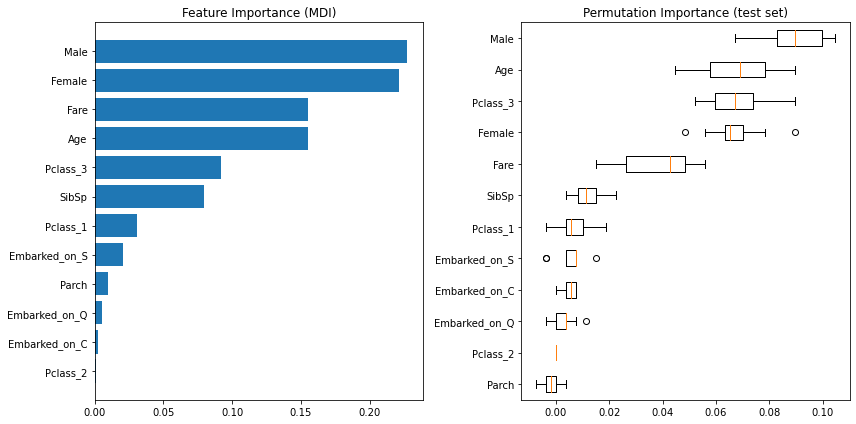

In [44]:
fig = plt.figure(figsize=(12, 6))

col = ['Age','SibSp', 'Parch', 'Fare', 'Pclass_1','Pclass_2','Pclass_3','Embarked_on_C','Embarked_on_Q','Embarked_on_S','Male','Female']
feature_importance = gradientboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 1)

plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(col)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(gradientboost, x_test_transformed, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(col)[sorted_idx])
plt.title("Permutation Importance (test set)")

fig.tight_layout()
plt.show()

### 6-2 Accuracy Curve

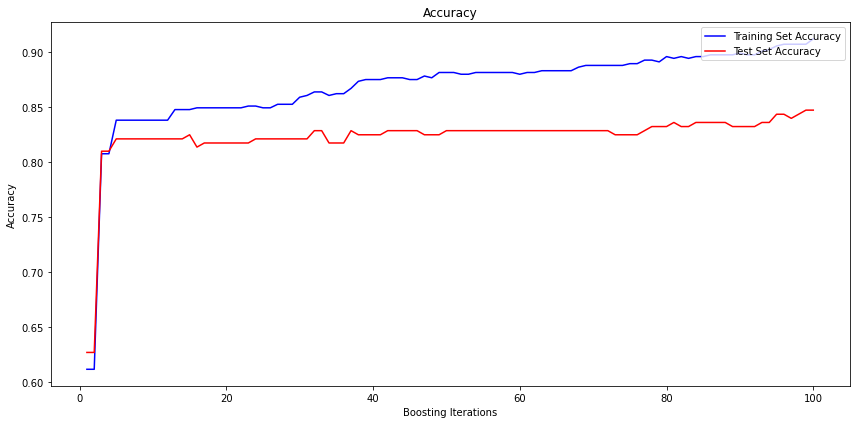

In [45]:
train_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(gradientboost.staged_predict(x_train_transformed)):
    train_score[i] = metrics.accuracy_score(y_train, y_pred)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(gradientboost.staged_predict(x_test_transformed)):
    test_score[i] = metrics.accuracy_score(y_test, y_pred)
    
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.title('Accuracy') # Binomial deviance loss function for binary classification
plt.plot(np.arange(params['n_estimators']) + 1, train_score, 'b-', label='Training Set Accuracy')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test Set Accuracy')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Accuracy')
fig.tight_layout()
plt.show()

### 6-3 ROC, AUC

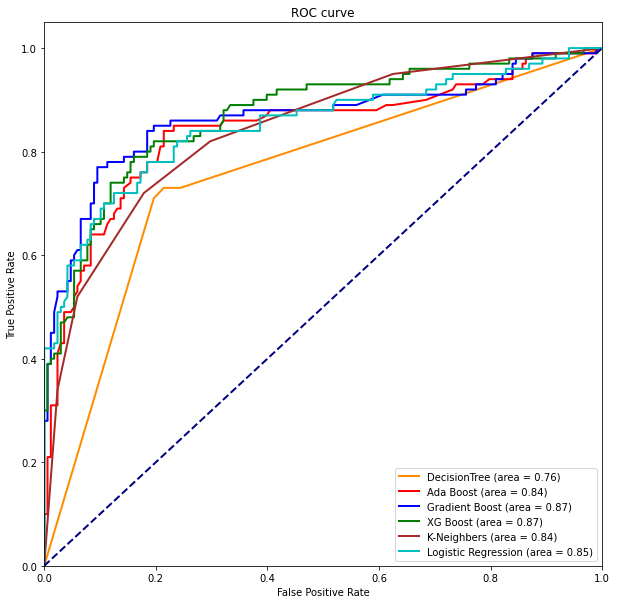

In [46]:
from sklearn.metrics import roc_curve, auc

fpr1, tpr1, _ = roc_curve(y_true=y_test, y_score=decisiontree.predict_proba(x_test_transformed)[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc1 = auc(fpr1, tpr1) # AUC 면적의 값 (수치)

fpr6, tpr6, _ = roc_curve(y_true=y_test, y_score=logisticlassfier.predict_proba(x_test_transformed)[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc6 = auc(fpr6, tpr6) # AUC 면적의 값 (수치)
# 
fpr2, tpr2, _ = roc_curve(y_true=y_test, y_score=adaboost.predict_proba(x_test_transformed)[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc2 = auc(fpr2, tpr2) # AUC 면적의 값 (수치)

fpr3, tpr3, _ = roc_curve(y_true=y_test, y_score=gradientboost.predict_proba(x_test_transformed)[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc3 = auc(fpr3, tpr3) # AUC 면적의 값 (수치)

fpr4, tpr4, _ = roc_curve(y_true=y_test, y_score=xgb_classfier.predict_proba(x_test_transformed)[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc4 = auc(fpr4, tpr4) # AUC 면적의 값 (수치)

fpr5, tpr5, _ = roc_curve(y_true=y_test, y_score=kneighbors.predict_proba(x_test_transformed)[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc5 = auc(fpr5, tpr5) # AUC 면적의 값 (수치)

#fpr, tpr, _ = roc_curve(y_true=y_test, y_score=support_vector_machine.predict_proba(x_test_transformed)[:,1]) # real y & predicted y (based on "Sepal width")
#roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)

plt.figure(figsize=(10, 10))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='DecisionTree (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', lw=2, label='Ada Boost (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='blue', lw=2, label='Gradient Boost (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='green', lw=2, label='XG Boost (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='brown', lw=2, label='K-Neighbers (area = %0.2f)' % roc_auc5)
plt.plot(fpr6, tpr6, color='c', lw=2, label='Logistic Regression (area = %0.2f)' % roc_auc6)


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")
plt.show()

### +) Grid Search

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time

start_time = time.time()

gb_clf = GradientBoostingClassifier()
gb_clf.fit(x_train_transformed, y_train)
gb_pred = gb_clf.predict(x_test_transformed)
gb_acc = accuracy_score(y_test, gb_pred)

print(f'모델 정확도: {gb_acc : .4f}')
print(f'학습 시간: {time.time()-start_time : .4f}')

from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[100, 250, 300, 350],
          'max_depth':[2, 3, 4, 5,],
          'min_samples_split': [3, 4,5,],
          'learning_rate': [0.01, 0.1],
          'random_state' : [0],
         }


grid_cv = GridSearchCV(gb_clf, param_grid=params,
                      n_jobs=-1, cv=2, verbose=1)
grid_cv.fit(x_train_transformed, y_train)

print(f'최적의 파라미터:', grid_cv.best_params_)
print(f'최고의 정확도:', grid_cv.best_score_)

모델 정확도:  0.8470
학습 시간:  0.0585
Fitting 2 folds for each of 96 candidates, totalling 192 fits
최적의 파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 300, 'random_state': 0}
최고의 정확도: 0.8089960013191524


In [48]:
params = {'n_estimators':300,
          'max_depth':3,
          'min_samples_split': 3,
          'learning_rate': 0.01,
          'random_state' : 0,
         }


gridsearched_gb = ensemble.GradientBoostingClassifier(**params)
gridsearched_gb.fit(x_train_transformed, y_train)
print('train 정확도 :',metrics.accuracy_score(y_train, gridsearched_gb.predict(x_train_transformed)))
print('test 정확도 :',metrics.accuracy_score(y_test, gridsearched_gb.predict(x_test_transformed)))   

train 정확도 : 0.8507223113964687
test 정확도 : 0.8171641791044776


## 7. Conclusion & Discussion

### 가장 정확도가 높은 모델 : 
`Gradient Boosting`

### 문헌과의 차이 :
* `Grid Search` 로 구한 가장 좋은 Hyper Parameter를 적용했을 때 모델 정확도가 0.85에서 0.82로 감소하였다.
* `Stacking` 으로 구한 두 정확도 중 Train정확도보다 Test정확도가 낮았다.

### 고찰 :
* Grid Search시 정확도가 낮아진 이유 -> `Cross Validation`시 한 fold당 표본개수가 부족하기 때문
    
### 후속과제 :
* Age컬럼 전처리 시 하나의 모델이 아닌 여러 개의 모델을 사용하여 정확도 교차검증
* Bayesian, Randomized Search 시행
* Ligt gbm 모델 추가시행
* `Name`칼럼을 추가해서 탑승자의 가문이 생존여부와 상관있는지 고찰, 모델 정확도 향상 기대
